# TP 1: Analisis Exploratorio
### Arrancando con Jupyter

In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Carga de archivos
post_educacion = pd.read_csv('../data/fiuba_1_postulantes_educacion.csv', dtype = {
    'nombre': 'category',
    'estado': 'category'
})
post_gen_edad = pd.read_csv('../data/fiuba_2_postulantes_genero_y_edad.csv', dtype = {
    'sexo': 'category'    
})

vistas = pd.read_csv('../data/fiuba_3_vistas.csv', parse_dates=['timestamp'])
postulaciones = pd.read_csv('../data/fiuba_4_postulaciones.csv', parse_dates=['fechapostulacion'])
avisos_online = pd.read_csv('../data/fiuba_5_avisos_online.csv')

avisos_detalles = pd.read_csv('../data/fiuba_6_avisos_detalle.csv', dtype= {
    'nombre_zona': 'category',
    'ciudad': 'category',
    'tipo_de_trabajo': 'category',
    'nivel_laboral': 'category',
    'nombre_area': 'category'
})

# Ajustes en los archivos antes de procesar

In [4]:
# Recorto la columna idpais ya que no es necesaria.
avisos_detalles.drop('idpais', axis=1, inplace=True)

In [5]:
# Agrego tipo categorico y modifico el tipo de dato de la fecha.
post_gen_edad.fechanacimiento = post_gen_edad.fechanacimiento.apply(pd.to_datetime, errors='coerce')

In [6]:
# Calculo el uso de memoria previamente para comparar despues.
# postulaciones.info(memory_usage='deep')

In [7]:
# Verifico cuanto cambio el consumo de memoria.
# postulaciones.info(memory_usage='deep')

# Empieza el analisis

In [8]:
# Asigno puntajes a los diferentes niveles educativos encontrados para poder 
# obtener asi la educacion mas valiosa de cada postulante.
valores_educacion = pd.DataFrame({
    'nombre': ['Otro',  'Otro',  'Otro',  'Secundario',  'Secundario',  'Secundario',  'Terciario/Técnico', 'Universitario',  \
              'Terciario/Técnico', 'Universitario',  'Terciario/Técnico', 'Universitario',  'Posgrado', 'Master','Posgrado', \
              'Master','Posgrado', 'Master','Doctorado','Doctorado','Doctorado'],
    'estado': ['Abandonado', 'En Curso','Graduado','Abandonado', 'En Curso','Graduado','Abandonado', 'Abandonado', 'En Curso',\
              'En Curso','Graduado','Graduado','Abandonado', 'Abandonado', 'En Curso','En Curso','Graduado','Graduado',\
              'Abandonado', 'En Curso','Graduado'],
    'valor_educacion': [1 , 2 , 3 , 4, 5,6 ,7 ,8 ,9,10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]})

# Y le pongo las mismas categorias que ya habia encontrado previamente.
valores_educacion.nombre = valores_educacion.nombre.astype((pd.api.types.CategoricalDtype(post_educacion.nombre.cat.categories)))
valores_educacion.estado = valores_educacion.estado.astype((pd.api.types.CategoricalDtype(post_educacion.estado.cat.categories)))

# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [9]:
# Hago el join para aplicar puntajes a las educaciones de los postulantes.
post_educacion = pd.merge(post_educacion, valores_educacion, how='inner', \
                          left_on=['nombre','estado'], right_on = ['nombre','estado'])

# Cuento cuantos registros tengo actualmente, para comprobar que no hay errores mas adelante.
# post_educacion.count()

In [10]:
# Busco la maxima educacion que tiene cada postulante.
max_post_educacion = post_educacion.groupby(['idpostulante'])['valor_educacion'].max().reset_index()

# Controlo cuantas lineas me devolvio.
max_post_educacion.count()

idpostulante       188752
valor_educacion    188752
dtype: int64

In [11]:
# Hago el join para filtrar todas las educaciones que no me interesan, dejando solo la maxima educacion.
post_educacion = pd.merge(post_educacion, max_post_educacion,  how='inner', \
                          left_on=['idpostulante','valor_educacion'], \
                          right_on = ['idpostulante','valor_educacion'])

# post_educacion.count()

In [12]:
post_educacion_graph = post_educacion.groupby(['nombre', 'estado', 'valor_educacion'])['idpostulante'].count().reset_index()
post_educacion_graph['resumen'] = post_educacion_graph.nombre.astype('object') + ' ' + post_educacion_graph.estado.astype('object')
post_educacion_graph.sort_values('valor_educacion', inplace=True)
post_educacion_graph.reset_index()
post_educacion_graph.drop(['nombre', 'estado', 'valor_educacion'], axis=1, inplace=True)
post_educacion_graph.rename(columns= {'idpostulante' : 'Cantidad de Postulantes'}, inplace=True)

post_educacion_graph.head(22)

,Cantidad de Postulantes,resumen
6,219,Otro Abandonado
7,186,Otro En Curso
8,933,Otro Graduado
12,2681,Secundario Abandonado
13,3397,Secundario En Curso
14,56333,Secundario Graduado
15,3034,Terciario/Técnico Abandonado
18,7122,Universitario Abandonado
16,10690,Terciario/Técnico En Curso
19,41097,Universitario En Curso


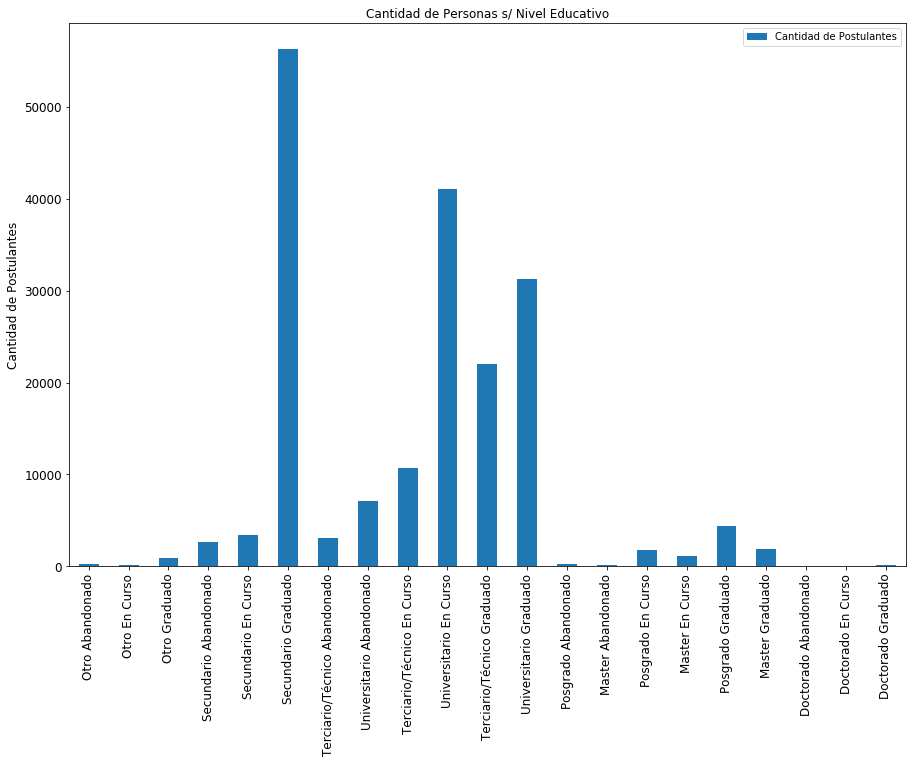

In [13]:
post_educacion_graph2 = post_educacion_graph[['resumen','Cantidad de Postulantes']].plot(kind='bar', x = 'resumen',                                                           
                                                           title ="Cantidad de Personas s/ Nivel Educativo", 
                                                           figsize=(15, 10), legend=True, fontsize=12)
post_educacion_graph2.set_xlabel("", fontsize=12)
post_educacion_graph2.set_ylabel("Cantidad de Postulantes", fontsize=12)
plt.show()

# Busco los avisos mas populares

In [14]:
# Busco cuales son los avisos mas populares, basandome en la cantidad de postulaciones sobre la cantidad de dias que lleva online.
avisos_popularidad = postulaciones.groupby(['idaviso'])['fechapostulacion'].agg(['min', 'max', 'count']).reset_index()
avisos_popularidad['cantidad_dias'] = (avisos_popularidad['max'] - \
                                       avisos_popularidad['min']).apply(lambda x: x.days).astype(int) + 1
avisos_popularidad.drop(['min', 'max'], axis=1, inplace=True)

avisos_popularidad['popularidad'] = avisos_popularidad['count'] / avisos_popularidad['cantidad_dias']
avisos_popularidad.drop(['count', 'cantidad_dias'], axis=1, inplace=True)
avisos_popularidad.sort_values('popularidad', ascending=False, inplace=True)

avisos_popularidad.head()

,idaviso,popularidad
12635,1112369306,2450.0
12447,1112366909,1442.5
12449,1112366913,1171.5
12519,1112368053,1055.0
12479,1112367832,1033.0


In [15]:
avisos_detalles = pd.merge(avisos_detalles, avisos_popularidad, how='inner', \
                          left_on='idaviso', right_on='idaviso')

In [16]:
avisos_detalles.sort_values('popularidad', ascending=False, )
avisos_detalles.head()

,idaviso,titulo,descripcion,nombre_zona,ciudad,mapacalle,tipo_de_trabajo,nivel_laboral,nombre_area,denominacion_empresa,popularidad
0,8725750,VENDEDOR/A PROVINCIA DE SANTA FE,<p><strong><strong>Empresa:</strong></strong> ...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Comercial,VENTOR,4.333333
1,1000610287,CHOFER DE CAMIONETA BAHIA BLANCA - PUNTA ALTA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Transporte,Wurth Argentina S.A,4.044444
2,1001135716,Vendedor Viajante TUCUMAN/SANTIAGO DEL ESTERO,<p>Somos una empresa multinacional que opera e...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Ventas,Wurth Argentina S.A,3.711111
3,1001326344,Vendedor Viajante RECONQUISTA/AVELLANEDA,<p><strong>Somos una empresa multinacional que...,Gran Buenos Aires,NaN,NaN,Full-time,Senior / Semi-Senior,Ventas,Wurth Argentina S.A,0.295455
4,1001455648,Vendedor Viajante PILAR / ESCOBAR/TIGRE,<p>Somos una empresa multinacional que opera e...,Gran Buenos Aires,NaN,NaN,Full-time,Junior,Ventas,Wurth Argentina S.A,3.911111


In [17]:
avisos_detalles['lugar_de_trabajo'] = \
    avisos_detalles.descripcion.str.extract(r'Lugar de trabajo:((\s*Av\. [^<\(-]*)|([^<.\(-]*))', expand=False)
avisos_detalles.lugar_de_trabajo = avisos_detalles.lugar_de_trabajo.str.replace('\x96|\xa0|\s+', ' ').str.strip().str.lower()
avisos_detalles.lugar_de_trabajo = avisos_detalles.lugar_de_trabajo.str.replace('ü', 'u').str.replace('á', 'a').str.replace('é', 'e')
avisos_detalles.lugar_de_trabajo = avisos_detalles.lugar_de_trabajo.str.replace('í', 'i').str.replace('ó', 'o').str.replace('ú', 'u')
avisos_detalles.lugar_de_trabajo.fillna(value='')
     
avisos_por_lugar_de_trabajo = avisos_detalles.groupby('lugar_de_trabajo')['idaviso'].count().reset_index()
avisos_por_lugar_de_trabajo.sort_values('idaviso', ascending=False, inplace=True)
avisos_por_lugar_de_trabajo.head(30)
#avisos_detalles[avisos_detalles['lugar_de_trabajo'].notnull()].head()

ValueError: Wrong number of items passed 3, placement implies 1